<a href="https://colab.research.google.com/github/Rachel-0420/Fast-Transient-Data/blob/main/PrestoColor2-main/Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict as odict
import time


# import Functions

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
Path1 = '/global/homes/l/lianming/Presto-Color-2/data/GSN_IDEAL_zALL_p1day'
Path2 = '/global/homes/l/lianming/Presto-Color-2/data/GSN_IDEAL_zALL_36min'
Path3 = '/content/drive/MyDrive/GSN_IDEAL_z02/'
PathTest = '/global/homes/l/lianming/Presto-Color-2/data/For_Test'

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict as odict
import time

def TestFunc(a, b):
    print('just for test!')
    return a/b

#Get the name of events as a dictionary, the event names are sorted.
def GetEventPaths(Path):

    PathsDict = {}
    FolderNames = os.listdir(Path)

    for FolderName in FolderNames:
        Ind = FolderName.find('MODEL')
        if Ind > -1:
            EventName = FolderName[Ind+8:]
            PathsDict[EventName] = os.path.join(Path, FolderName)
    return dict(sorted(PathsDict.items()))

def ReadData(Path, EventName, FileNo, ObjNo=None):

    PathsDict = GetEventPaths(Path)
    SubPath = PathsDict[EventName]

    FileNames = os.listdir(SubPath)
    FileNames.sort()

    Data = read_snana_fits(os.path.join(SubPath,FileNames[FileNo*2]),os.path.join(SubPath,FileNames[FileNo*2+1]))

    if ObjNo == None:
        return Data
    else:
        return Data[ObjNo]


# FileNo and ObjNo given in 0, 1, 2, 3... to N-1.
def PlotLightCurve(Path, Band, EventName=None, SeedFile=None, SeedObj=None, Prop='SIM_MAGOBS' , thr=27.5,
                   AlignPeak=True,FigNo=None, FileNo=None, ObjNo=None, ls=None, PlotSizeRatio=1, Space=False,
                   marker=None, sharex=True, sharey='none', Range=[0, 200], Shadow=None, xlim=None, ylim=None):
    """
    asfasfasfdasf.
    """

    if len(Band) == 1:
        Band = Band+' '

    if Band not in ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']:
        print('The band input does not exist.')
        return

    if Prop not in ['SIM_MAGOBS', 'FLUXCAL']:
        print("The input for Prop should be 'SIM_MAGOBS' or 'FLUXCAL'")
        return

    PathsDict = GetEventPaths(Path)

    if EventName == None:
        print('Please provide the event name. Available events are:')
        return list(PathsDict.keys())


    if FigNo == None:
        FigNo = 25
    RowNo, ColNo = RowColNo(FigNo)

    SubPath = PathsDict[EventName]

    FileNames = os.listdir(SubPath)
    FileNames.sort()

    Mask = ['HEAD' in FileName for FileName in FileNames]
    TotFileNo = sum(Mask)

    if FileNo is None:
        np.random.seed(SeedFile)
        FileNo = np.random.randint(0,TotFileNo-1,RowNo)
    else:
        if any([II>TotFileNo for II in FileNo]):
            print('The FileNo excceed the limit.')

    if ObjNo is None:
        np.random.seed(SeedObj)
        ObjNoRatio = np.random.rand(ColNo)
        FigNo = len(FileNo) * len(ObjNoRatio)
    else:
        FigNo = len(FileNo) * len(ObjNo)

    RowNo, ColNo = RowColNo(FigNo)

    if sharex == True:
        fig, axs = plt.subplots(RowNo, ColNo,
                                figsize = (6*ColNo*PlotSizeRatio, 3*RowNo*PlotSizeRatio),
                                sharex=sharex, sharey=sharey)
        fig.subplots_adjust(hspace=0.05)
        if Space==False:
            fig.subplots_adjust(hspace=0, wspace=0)
    else:
        fig, axs = plt.subplots( RowNo, ColNo,
                                figsize = (6*ColNo*PlotSizeRatio, 4.5*RowNo*PlotSizeRatio),
                                sharex=sharex, sharey=sharey)
        if Space==False:
            fig.subplots_adjust(wspace=0)

    axsflat = axs.flatten()

    for II, FNo in enumerate(FileNo):
        Data = read_snana_fits(os.path.join(SubPath,FileNames[FNo*2]),
                               os.path.join(SubPath,FileNames[FNo*2+1]))

        if ObjNo is None:
            ObjNo = ObjNoRatio*len(Data)
            ObjNo = ObjNo.astype(int)

        for JJ, ONo in enumerate(ObjNo):

#             Mask1 = Data[ONo]['SIM_MAGOBS'] < 30
#             Mask2 = Data[ONo]['SIM_MAGOBS'] > 40
#             Data[ONo][Prop][ Mask1+Mask2 ] = None

            Data[ONo][Prop][ Data[ONo]['SIM_MAGOBS']>thr ] = None
            MaskBand = Data[ONo]['BAND'] == Band

            # while np.nanmax(Data[ONo]['SIM_MAGOBS'][MaskBand])-np.nanmin(Data[ONo]['SIM_MAGOBS'][MaskBand]) < 1:
            #     ONo += 1

            if AlignPeak==True:
                Ind = np.where( Data[ONo]['SIM_MAGOBS'][MaskBand] == np.nanmin(Data[ONo]['SIM_MAGOBS'][MaskBand]) )[0][0]
                ZeroDay = Data[ONo]['MJD'][MaskBand][Ind]
            else:
                ZeroDay = min(Data[ONo]['MJD'][MaskBand][Range[0]:Range[1]])

            axsflat[II*ColNo+JJ].plot(Data[ONo]['MJD'][MaskBand][Range[0]:Range[1]]-ZeroDay,
                                      Data[ONo][Prop][MaskBand][Range[0]:Range[1]], ls = ls, marker = marker)
            axsflat[II*ColNo+JJ].text(0.95, 0.95, '({}, {})'.format(II+1, JJ+1),
                                      ha='right', va='top', transform=axsflat[II*ColNo+JJ].transAxes)

            if Space==False:
                axsflat[II*ColNo+JJ].tick_params('y', direction='in', pad=-5)
                plt.setp(axsflat[II*ColNo+JJ].get_yticklabels(), ha="left")

            if Shadow!=None:

                Xlim = axsflat[II*ColNo+JJ].get_xlim()
                Ylim = axsflat[II*ColNo+JJ].get_ylim()
                axsflat[II*ColNo+JJ].fill_between(Xlim, np.ones_like(Xlim)*Shadow,
                                                  np.ones_like(Xlim)*Ylim[1], color=(0,0,0,0.1))
                axsflat[II*ColNo+JJ].set_xlim(Xlim)
                axsflat[II*ColNo+JJ].set_ylim(Ylim)

    if xlim != None:
        if sharex == True:
            axsflat[0].set_xlim(xlim)
        else:
            for ax in axsflat:
                ax.set_xlim(xlim)

    if ylim != None:
        if sharey == True:
            axsflat[0].set_ylim(ylim)
        else:
            for ax in axsflat:
                ax.set_ylim(ylim)

    if Prop == 'SIM_MAGOBS':
        if sharey == True:
            axsflat[0].invert_yaxis()
        else:
            for ax in axsflat:
                ax.invert_yaxis()

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False )

    plt.xlabel('Time (days)', fontsize=15, labelpad=15)
    if Prop == 'SIM_MAGOBS':
        if Space==True:
            plt.ylabel('Apparent Magnitude', fontsize=15, labelpad=25)
        else:
            plt.ylabel('Apparent Magnitude', fontsize=15)
    else:
        if Space==True:
            plt.ylabel(Prop, fontsize=15, labelpad=20)
        else:
            plt.ylabel(Prop, fontsize=15)

    print('The threshold for the magnitude is {}.'.format(thr))
    print('The objects plotted are from FileNo={}, ObjNo={}'.format(list(FileNo), list(ObjNo)))
    return FileNo, ObjNo


#Calculate Map Function for the "cube"
def CalculateMap(Interp_load, TimeRange_load, Band1, Band2, dT1, dT2,
                 PointsPDay = 50, Thrs=None, ObjNo=None, SeedObj=None, SaveData=0, TargetFolder='MapData'):

    dMag = []
    Color = []

    if Thrs == None:
        Thrs = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'Y': 22.1}

    TotalObjNo = len(Interp_load[Band1])

    if ObjNo == None:
        ObjInd = range(TotalObjNo)
    elif ObjNo < 0.1*TotalObjNo:
        np.random.seed(SeedObj)
        ObjInd = np.random.randint(0, TotalObjNo, size=ObjNo)
    elif ObjNo > TotalObjNo:
        raise ValueError('The No of Objects excceeds limit. The total No is {}'.format(TotalObjNo))
    else:
        ObjInd = range(ObjNo)

    for II in ObjInd:

        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue

        # if II%5000 == 4999:
        #     print('|')
        # elif II%50 == 49:
        #     print('|', end='' )

        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)

        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart

        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)

        Mask = (Mag1<Thrs[Band1]) * (Mag2<Thrs[Band2]) *(Mag12<Thrs[Band1])

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])

    data = np.array([dMag, Color])

    if SaveData == 1:

        TargetPath = os.path.join(Path0, TargetFolder)
        if not os.path.isdir(TargetPath):
            os.mkdir(TargetPath)
        os.chdir(TargetPath)

        Ind1 = PathInterp.rfind('/')
        Ind2 = PathInterp.rfind('_')

        FileName = '{}{}_dT1_{}_dT2_{}_PPD{}_Thr{}_{}_Source_{}.npy'.format(Band1, Band2, dT1, dT2,
                                                                            PointsPDay, Thr, EventName,
                                                                            PathInterp[Ind1+1:Ind2])
        np.save(FileName, data)

        print('The data is saved at {} as {}.'.format(TargetPath, FileName))

    return data


#Calculate Map Function for the "cube"
def CalculateMap1(Interp_load, TimeRange_load, Band1, Band2, dT1, dT2,
                 PointsPDay = 50, Thr=27.5, ObjNo=None, SaveData=0, TargetFolder='MapData'):

    dMag = []
    Color = []

    if ObjNo == None:
        ObjNo = len(Interp_load[Band1])

    for II in range(ObjNo):

        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue

        # if II%5000 == 4999:
        #     print('|')
        # elif II%50 == 49:
        #     print('|', end='' )

        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)

        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart

        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)

        Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])

    data = np.array([dMag, Color])

    if SaveData == 1:

        TargetPath = os.path.join(Path0, TargetFolder)
        if not os.path.isdir(TargetPath):
            os.mkdir(TargetPath)
        os.chdir(TargetPath)

        Ind1 = PathInterp.rfind('/')
        Ind2 = PathInterp.rfind('_')

        FileName = '{}{}_dT1_{}_dT2_{}_PPD{}_Thr{}_{}_Source_{}.npy'.format(Band1, Band2, dT1, dT2,
                                                                            PointsPDay, Thr, EventName,
                                                                            PathInterp[Ind1+1:Ind2])
        np.save(FileName, data)

        print('The data is saved at {} as {}.'.format(TargetPath, FileName))

    return data



#Count the sizes of the HEAD files and PHOT files respectively.
def GetFileSize(Path, output=0, plot=1):

    SizesH = []
    SizesP = []

    PathsDict = GetEventPaths(Path)

    for Event in PathsDict:

        SubPath = PathsDict[Event]
        FileNames = os.listdir(SubPath)

        SizeH = 0
        SizeP = 0

        for FileName in FileNames:

            if FileName.find('HEAD') > -1:

                FilePath = os.path.join(SubPath, FileName)
                SizeH = SizeH + os.path.getsize(FilePath)

            elif FileName.find('PHOT') > -1:
                FilePath = os.path.join(SubPath, FileName)
                SizeP = SizeP + os.path.getsize(FilePath)

        SizesH.append(SizeH)
        SizesP.append(SizeP)

    SizeHMB = np.array(SizesH) / 1024**2
    SizePMB = np.array(SizesP) / 1024**2

    if plot == 1:

        plt.figure(figsize=(15,5))

        plt.bar(PathsDict.keys(), SizeHMB)
        plt.xticks(rotation = 60)
        plt.xlabel('Event Names')
        plt.ylabel('Sizes of Head Files (MB)')
        plt.title('The total size is {} MB'.format(SizeHMB.sum()))

        plt.figure(figsize=(15,5))

        plt.bar(PathsDict.keys(), SizePMB)
        plt.xticks(rotation = 60)
        plt.xlabel('Event Names')
        plt.ylabel('Sizes of Phot Files (MB)')
        plt.title('The total size is {} MB'.format(SizePMB.sum()))

    if output == 1:
        return SizeHMB, SizePMB

#Count the observation numbers of each object contained in the given path
def GetObsNum(Path, output=0, plot=1):

    PathsDict = GetEventPaths(Path)
    Bands = ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']

    ObjectNums = []

    ObsNums =  [ [] for _ in range(len(Bands)) ]
    ObsNumStd = [ [] for _ in range(len(Bands)) ]

    for Event in PathsDict:

        print('Counting {:<25}'.format(Event+':'), end='')
        start = time.time()

        SubPath = PathsDict[Event]
        FileNames = os.listdir(SubPath)

        ObjectNum = 0
        ObjObsNums = [ [] for _ in range(len(Bands)) ]

        for FileName in FileNames:

            Ind = FileName.find('HEAD')

            if Ind > -1:

                print('|', end='')

                FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

                HeadFilePath = os.path.join(SubPath, FileName)
                PhotFilePath = os.path.join(SubPath, FileNamePHOT)
                Data = read_snana_fits(HeadFilePath, PhotFilePath)

                FileObjNum = len(Data)
                ObjectNum = ObjectNum + FileObjNum

                for Obj in Data:

                    for II, Band in enumerate(Bands):

                        Mask = Obj['BAND'] == Band
                        ObjObsNums[II].append(Mask.sum())

        ObjectNums.append(ObjectNum)

        ObjObsNumsMean = np.mean(ObjObsNums, 1)
        ObjObsNumsStd = np.std(ObjObsNums, 1, ddof=1)

        for II in range(len(Bands)):

            ObsNums[II].append(ObjObsNumsMean[II])
            ObsNumStd[II].append(ObjObsNumsStd[II])

#         [ [ObsNums[II].append(ObjObsNumsMean[II]), [ObsNumStd[II].append(ObjObsNumsStd[II])] ] for II in range(len(Bands)) ]

        end = time.time()

        print('\t time spent: {0:6.3f} s'.format(end-start))

    if plot == 1:

        plt.figure(figsize=(15,5))

        plt.bar(PathsDict.keys(), ObjectNums)
        plt.xticks(rotation = 60)
        plt.xlabel('Event Names')
        plt.ylabel('Number of Objects')

        fig, axs = plt.subplots(6, 1, figsize=(15,15), sharex=True, sharey=True)
#         fig.subplots_adjust(hspace=0)

        for II, ax in enumerate(axs.flat):

            ax.bar(PathsDict.keys(), ObsNums[II])
            ax.errorbar(PathsDict.keys(), ObsNums[II], ObsNumStd[II], fmt='o', color = 'r')
            ax.text(0.99, 0.99, 'Band '+Bands[II], transform=ax.transAxes, ha='right', va='top')

            ax.tick_params(axis='x', rotation=60)

        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False )

#         plt.xlabel('Event Names', fontsize=15 )
        plt.ylabel('Number of Observations', fontsize=15)
#         plt.title('Statistics for Observation Numbers', fontsize = 20, loc='center')

        if output == 1:

            return PathsDict.keys(), ObsNums, ObsNumStd



# Find out the gaps between observations
def GetObsGaps(Path, Band, Events=None, output=0, plot=1):

    PathsDict = GetEventPaths(Path)
    EventNames = list(PathsDict.keys())

    GapMean = []
    GapStd = []


    if len(Band) == 1:
        Band = Band+' '

    if Band not in ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']:
        print('The band input does not exist.')
        return

    if Events == None:
        Events = list(PathsDict.keys())

    if isinstance(Events, str):
        Events = [Events]

    for Event in Events:

        print('Counting {:<25}'.format(Event+':'), end='')
        start = time.time()

        SubPath = PathsDict[Event]
        FileNames = os.listdir(SubPath)

        #Start counting one type of events.

        Gaps = []

        for FileName in FileNames:

            Ind = FileName.find('HEAD')

            if Ind > -1:

                print('|', end='')

                FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

                HeadFilePath = os.path.join(SubPath, FileName)
                PhotFilePath = os.path.join(SubPath, FileNamePHOT)
#                 Data = np.array(read_snana_fits(HeadFilePath, PhotFilePath))
                Data = read_snana_fits(HeadFilePath, PhotFilePath)
#                 Data = np.array(Data)

                for Obj in Data:
                    Mask = Obj['BAND']==Band
                    Gaps.append(Obj['MJD'][Mask][1:] - Obj['MJD'][Mask][:-1])

        GapsArray = np.array(Gaps)

        GapMean.append(GapsArray.mean(axis=0))
        GapStd.append(GapsArray.std(axis=0, ddof=1))

        end = time.time()

        print('\t time spent: {0:6.3f} s'.format(end-start))

    GapMean = [np.round(II, 2) for II in GapMean]
    GapStd = [np.round(II, 2) for II in GapStd]

    #Plot
    FigNo = len(Events)

    RowNo, ColNo = RowColNo(FigNo)

    fig, axs = plt.subplots( RowNo, ColNo, figsize = (20, 4*RowNo,), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0, wspace=0)

    axflat = axs.flatten()

    for II in range(FigNo):

        axflat[II].plot(GapMean[II])
        axflat[II].text(0.05, 0.95, Events[II], fontsize=10, ha='left', va='top', transform=axflat[II].transAxes)

    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False )

    plt.xlabel("Number of observation", fontsize=15)
    plt.ylabel("Observation gaps of band {}(MJD)".format(Band), fontsize=15)

    if output==1:
        return GapMean



#Find out the peak magnitudes of the objects of a given class.
def GetPeakMag(Path, EventName, output=0, plot=1):

    PathsDict = GetEventPaths(Path)
    Bands = ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']

    SubPath = PathsDict[EventName]
    FileNames = os.listdir(SubPath)

    PeakMags = [ [] for _ in range(len(Bands)) ]

    for FileName in FileNames:

        Ind = FileName.find('HEAD')

        if Ind > -1:

            print('|', end='')

            FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

            HeadFilePath = os.path.join(SubPath, FileName)
            PhotFilePath = os.path.join(SubPath, FileNamePHOT)
            Data = read_snana_fits(HeadFilePath, PhotFilePath)


            for Obj in Data:

                for II, Band in enumerate(Bands):

                    MaskBand = Obj['BAND'] == Band
                    PeakMags[II].append( min(Obj['SIM_MAGOBS'][MaskBand]) )

    if plot == 1:

        fig, ax = plt.subplots(1,1, figsize=(15,5))

        ax.boxplot(PeakMags)
        ax.set_xticklabels([Band[0] for Band in Bands])

        plt.xlabel('Bands')
        plt.ylabel('Peak Magnitudes')
        plt.title(EventName)

        fig, axs = plt.subplots(6, 1, figsize=(15,15), sharex=True, sharey=True)

#         fig.subplots_adjust(hspace=0)

        for II, ax in enumerate(axs.flat):

            ax.plot(PeakMags[II])
            ax.text(0.99, 0.95, 'Band '+Bands[II], transform=ax.transAxes, ha='right', va='top')

        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False )

        plt.ylabel('Peak Magnitudes', fontsize=15)
        plt.xlabel('Object Count', fontsize=15)

        if output == 1:
            return PeakMags



#Find the range in time of the objects.
def GetTimeRange(Path, Band, Events=None, Prop='MJD', output=0, plot=1):

    print('bbb')

    PathsDict = GetEventPaths(Path)
    EventNames = list(PathsDict.keys())

    StartMean = []
    StartStd = []
    EndMean = []
    EndStd = []

    if len(Band) == 1:
        Band = Band+' '

    if Band not in ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']:
        print('The band input does not exist.')
        return

    if Events == None:
        Events = list(PathsDict.keys())

    for Event in Events:

        print('Counting {:<25}'.format(Event+':'), end='')
        start = time.time()

        SubPath = PathsDict[Event]
        FileNames = os.listdir(SubPath)

        #Start counting one type of events.

        Gaps = []

        Starts = []
        Ends = []

        for FileName in FileNames:

            Ind = FileName.find('HEAD')

            if Ind > -1:

                print('|', end='')

                FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

                HeadFilePath = os.path.join(SubPath, FileName)
                PhotFilePath = os.path.join(SubPath, FileNamePHOT)
#                 Data = np.array(read_snana_fits(HeadFilePath, PhotFilePath))
                Data = read_snana_fits(HeadFilePath, PhotFilePath)
#                 Data = np.array(Data)

                for Obj in Data:
                    Mask = Obj['BAND']==Band

                    Starts.append(Obj['MJD'][Mask][0])
                    Ends.append(Obj['MJD'][Mask][-1])

        GapsArray = np.array(Gaps)

        StartMean.append(np.mean(Starts))
        StartStd.append(np.std(Starts, ddof=1))

        EndMean.append(np.mean(Ends))
        EndStd.append(np.std(Ends, ddof=1))

        end = time.time()
        print('\t time spent: {0:6.3f} s'.format(end-start))

    if plot == 1:

        plt.figure(figsize=(15,5))

        plt.plot(Events, StartMean)
        plt.errorbar(Events, StartMean, StartStd)

        plt.plot(Events, EndMean)
        plt.errorbar(Events, EndMean, EndStd)

        plt.xticks(rotation = 60)
        plt.xlabel('Event Names')
        plt.ylabel('Start and End Time')


    if output == 1:
        return StartMean, StartStd, EndMean, EndStd



def CountMag99(Path, EventName):

    PathsDict = GetEventPaths(Path)
    SubPath = PathsDict[EventName]

    FileNames = os.listdir(SubPath)
    FileNames.sort()

    Bands = ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']

    Mag99No = []

    for FileName in FileNames[0:1]:

        Ind = FileName.find('HEAD')

        if Ind > -1:

            print('|', end='')

            FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

            Data = read_snana_fits(os.path.join(SubPath, FileName), os.path.join(SubPath, FileNamePHOT))



            for Obj in Data[0:50]:

                ObjMag99No = []

                for Band in Bands:

                    Mask = Obj['BAND'] == Band
                    ObjMag99No.append(sum(Obj['SIM_MAGOBS'][Mask] == 99))

                Mag99No.append(ObjMag99No)

#                 if any([ ii!=ObjMag99No[0] for ii in ObjMag99No ]):
#                     print('Unequal Mag99 found!')

    plt.figure(figsize=[20,10])

    plt.plot(np.array(Mag99No))
    plt.legend([Band[0] for Band in Bands])


def BandInNo(Band):
    Bands = ['u', 'g', 'r', 'i', 'z', 'Y']

    try:
        Ind = Bands.index(Band)
        return Ind

    except ValueError:
        print('Wrong bands input! The available bands are:\n{}'.format(Bands))


# Return the row and column numbers of a subplot according to the number of the plots.
def RowColNo(FigNo):

    if FigNo<7:
        ColNo = 2
    elif FigNo<13:
        ColNo = 3
    elif FigNo<21:
        ColNo = 4
    else:
        ColNo = 5
    RowNo = int(np.ceil(FigNo/ColNo))
    return RowNo, ColNo

#Funtion from https://sncosmo.readthedocs.io/en/v2.1.x/api/sncosmo.read_snana_fits.html
def read_snana_fits(head_file, phot_file, snids=None, n=None):

    # Should we memmap? Only if we're going to read only a part of the file
    memmap = (snids is not None or n is not None)

    # Get metadata for all the SNe
    head_data = fits.getdata(head_file, 1, view=np.ndarray)
    phot_data = fits.getdata(phot_file, 1, view=np.ndarray, memmap=memmap)

    # Strip trailing whitespace characters from SNID.
    if 'SNID' in head_data.dtype.names:
        try:
            head_data['SNID'][:] = np.char.strip(head_data['SNID'])
        except TypeError:
            pass

    # Check which indicies to return.
    if snids is None and n is None:
        idx = range(len(head_data))
    elif n is None:
        if 'SNID' not in head_data.dtype.names:
            raise RuntimeError('Specific snids requested, but head file does'
                               ' not contain SNID column')
        idx = []
        for snid in snids:
            i = np.flatnonzero(head_data['SNID'] == snid)
            if len(i) != 1:
                raise RuntimeError('Unique snid requested, but there are '
                                   '{0:d} matching entries'.format(len(i)))
            idx.append(i[0])
    elif snids is None:
        idx = range(n)
    else:
        raise ValueError("cannot specify both 'snids' and 'n' arguments")

    # Loop over SNe in HEAD file
    sne = []
    for i in idx:
        meta = odict(zip(head_data.dtype.names, head_data[i]))

        j0 = head_data['PTROBS_MIN'][i] - 1
        j1 = head_data['PTROBS_MAX'][i]
        data = phot_data[j0:j1]
        if 'FLT' in data.dtype.names:
            data['FLT'][:] = np.char.strip(data['FLT'])
        sne.append(Table(data, meta=meta, copy=False))

    return sne

In [20]:
PlotLightCurve(Path1, 'g', 'KN_B19', Space=True, FigNo=9, Shadow=25, thr=30, PlotSizeRatio=0.75, FileNo=[4, 15, 0], ObjNo=[183, 41, 98]
)

FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/l/lianming/Presto-Color-2/data/GSN_IDEAL_zALL_p1day'

The threshold for the magnitude is 35.
The objects plotted are from FileNo=[8, 11, 1], ObjNo=[1599, 1269, 1283]


(array([ 8, 11,  1]), array([1599, 1269, 1283]))

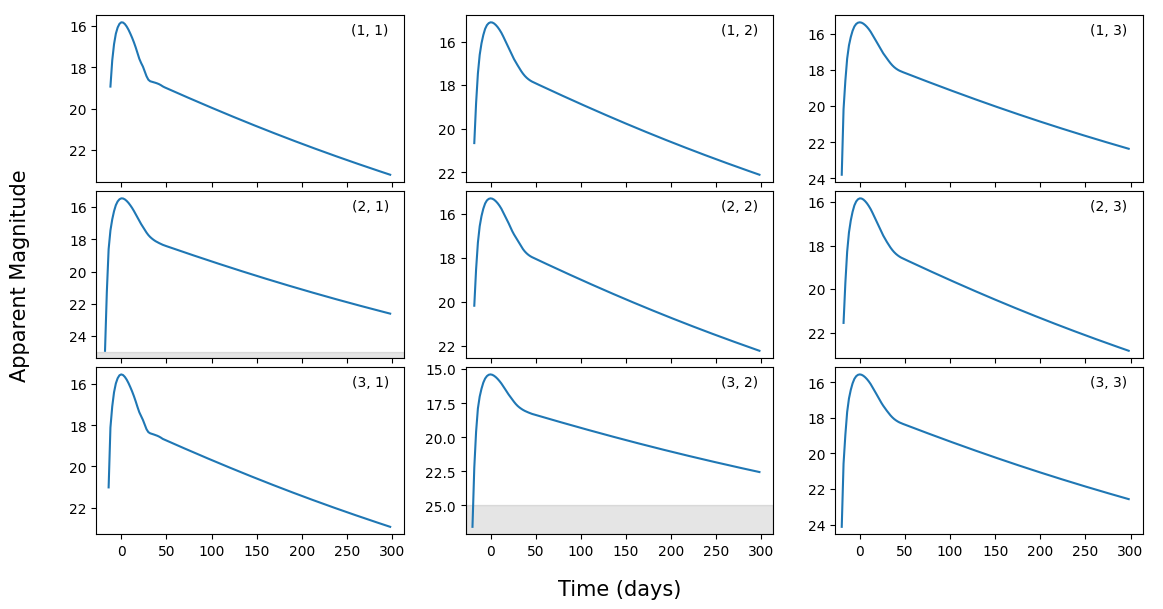

In [10]:
PlotLightCurve(Path3, 'g', 'SNIa-SALT2', FigNo=9, thr=35, Space=True, Shadow=25, PlotSizeRatio=0.75)

The threshold for the magnitude is 35.
The objects plotted are from FileNo=[8, 2, 14], ObjNo=[1708, 221, 1559]


(array([ 8,  2, 14]), array([1708,  221, 1559]))

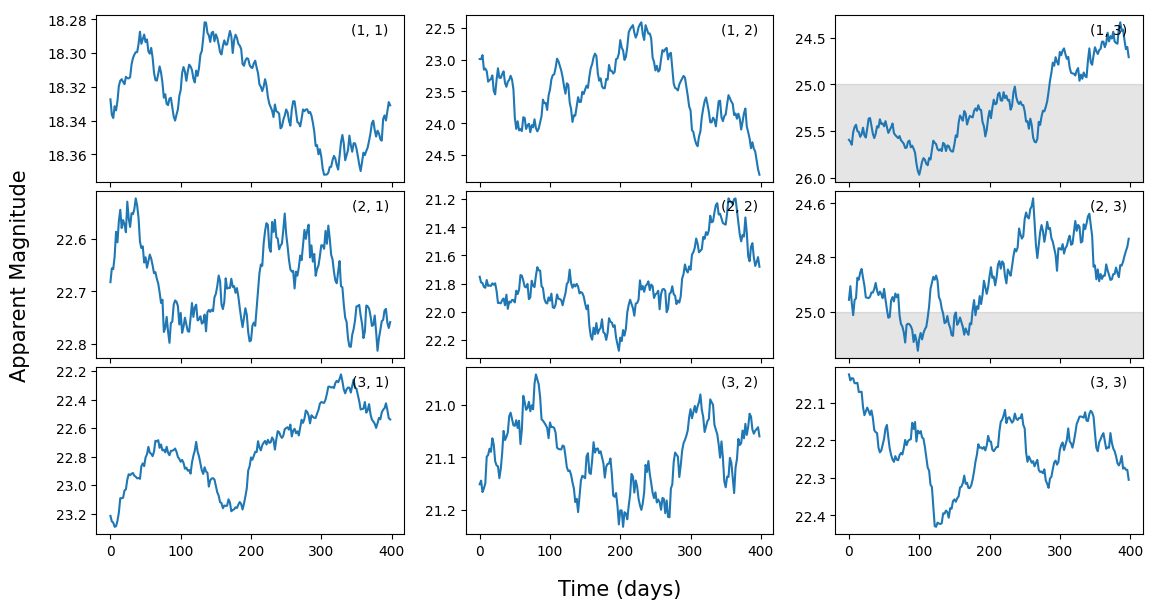

In [9]:
PlotLightCurve(Path3, 'g', 'AGN', FigNo=9, PlotSizeRatio=0.75, thr=35, Space=True, AlignPeak=False, Shadow=25)

The threshold for the magnitude is 35.
The objects plotted are from FileNo=[8, 3, 12], ObjNo=[1233, 1797, 126]


(array([ 8,  3, 12]), array([1233, 1797,  126]))

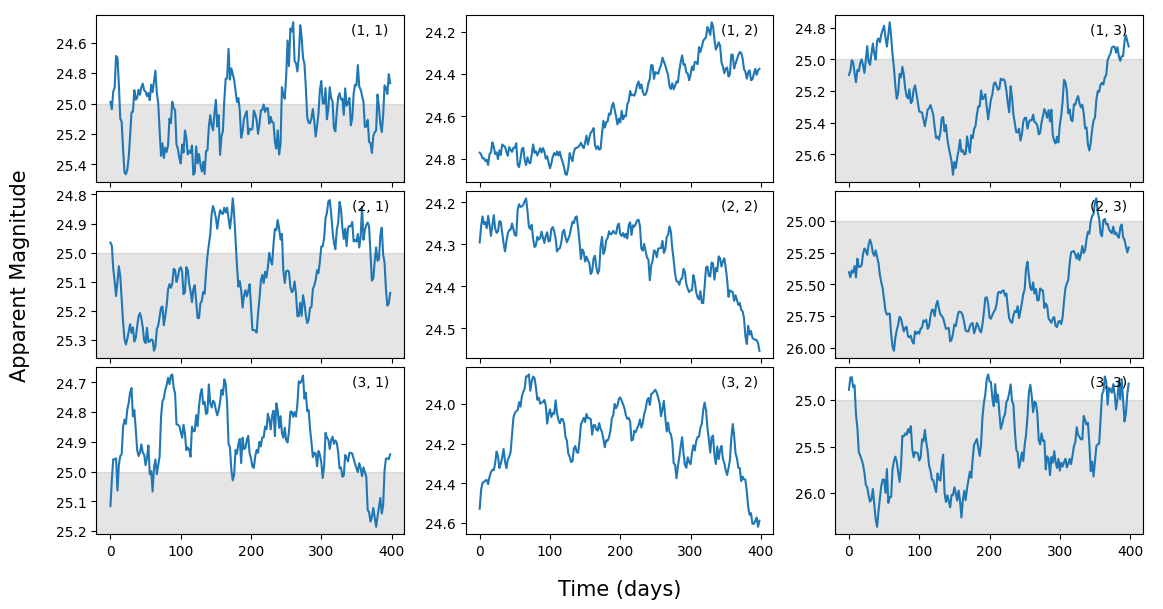

In [11]:
PlotLightCurve(Path3, 'g', 'AGN', FigNo=9, PlotSizeRatio=0.75, thr=35, Space=True, AlignPeak=False, Shadow=25)

The threshold for the magnitude is 35.
The objects plotted are from FileNo=[16, 8, 1], ObjNo=[959, 1467, 48]


(array([16,  8,  1]), array([ 959, 1467,   48]))

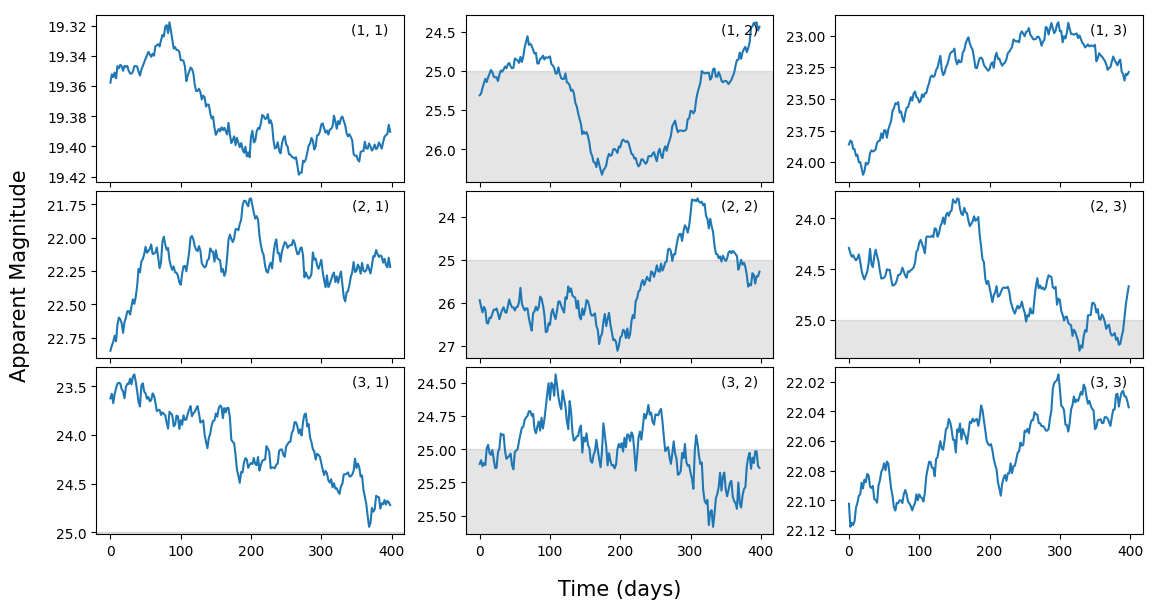

In [12]:
PlotLightCurve(Path3, 'g', 'AGN', FigNo=9, PlotSizeRatio=0.75, thr=35, Space=True, AlignPeak=False, Shadow=25)

In [14]:
myquota

NameError: name 'myquota' is not defined

In [15]:
aa = np.random.rand(5)

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[3, 14, 17], ObjNo=[512, 1733, 59]


Text(0.5, 1.0, 'V19_CC+HostXT')

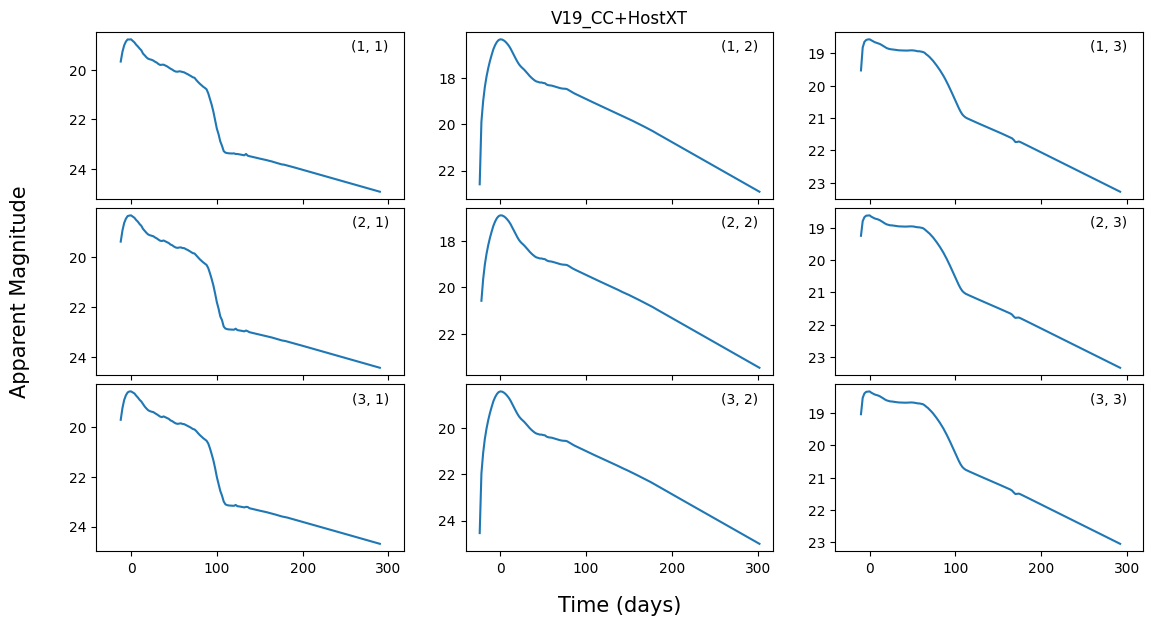

In [16]:
PlotLightCurve(Path3, 'g', 'V19_CC+HostXT', FigNo=9, PlotSizeRatio=0.75, thr=30, Space=True, AlignPeak=True)
plt.title('V19_CC+HostXT')

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[11, 12, 3], ObjNo=[1613, 1338, 1815]


(array([11, 12,  3]), array([1613, 1338, 1815]))

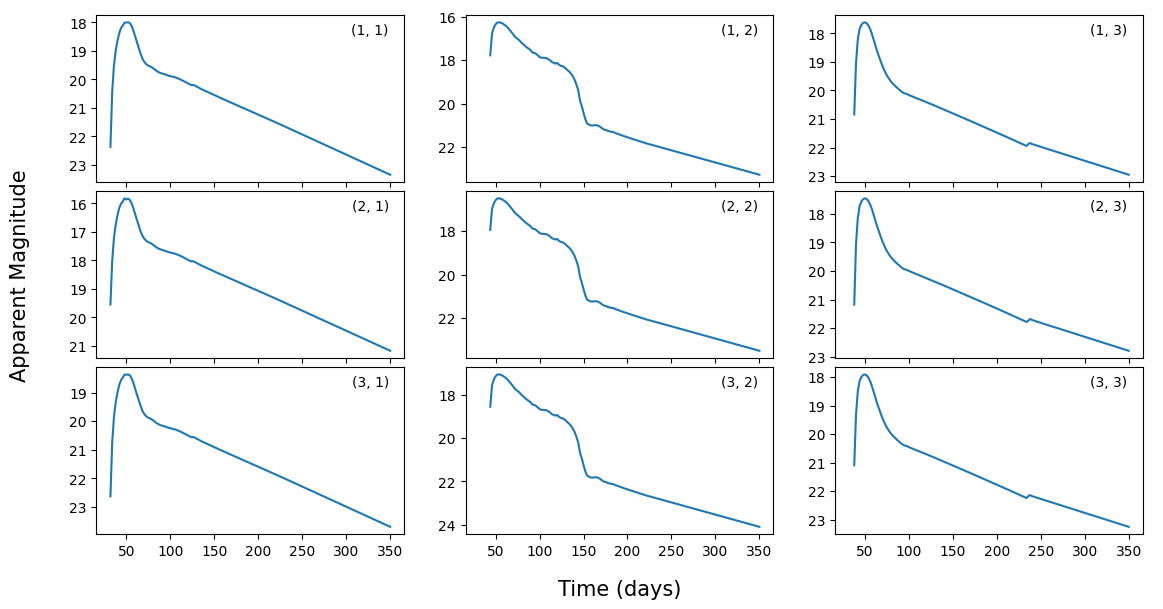

In [17]:
PlotLightCurve(Path3, 'g', 'V19_CC+HostXT', FigNo=9, PlotSizeRatio=0.75, thr=30, Space=True, AlignPeak=False)

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[13, 14, 2], ObjNo=[1281, 1478, 627]


(array([13, 14,  2]), array([1281, 1478,  627]))

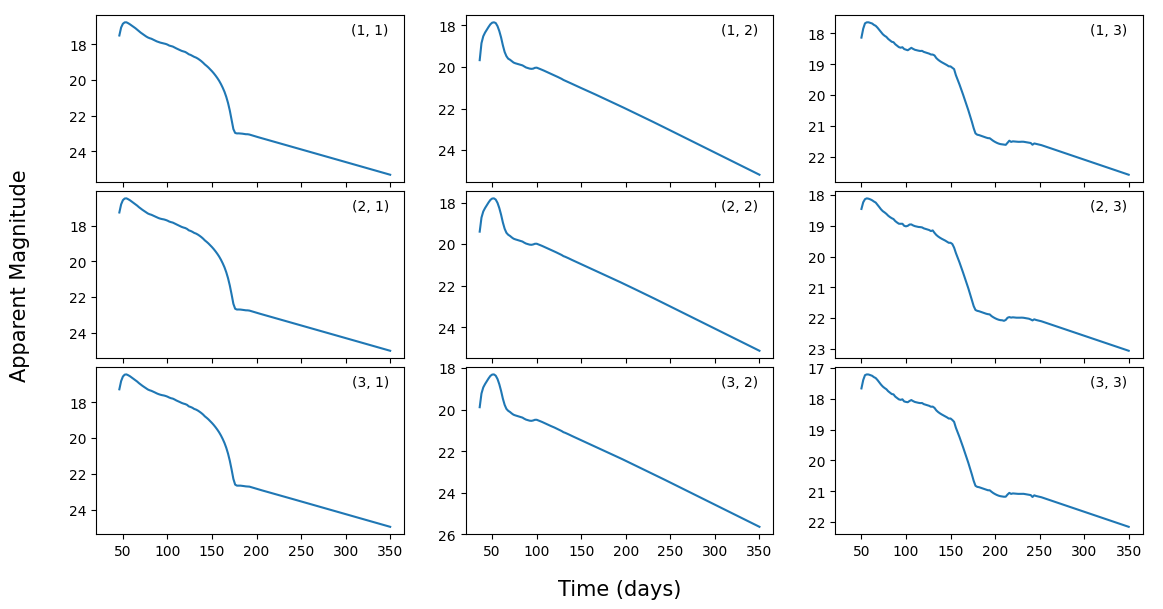

In [18]:
PlotLightCurve(Path3, 'g', 'V19_CC+HostXT', FigNo=9, PlotSizeRatio=0.75, thr=30, Space=True, AlignPeak=False)

In [ ]:
10//3

3

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[2, 7, 17], ObjNo=[142, 71, 39]


(array([ 2,  7, 17]), array([142,  71,  39]))

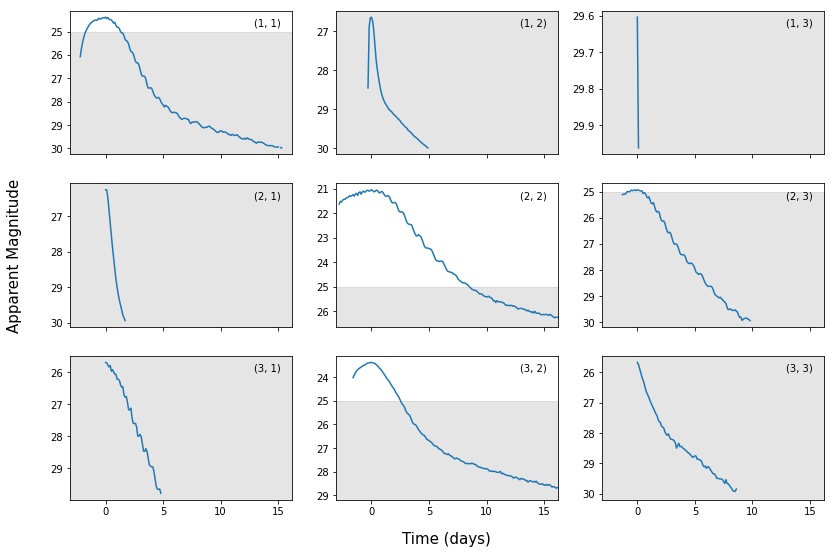

In [ ]:
Functions.PlotLightCurve(Path1, 'r', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=30, PlotSizeRatio=0.75)

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[0, 11, 3], ObjNo=[155, 10, 28]


(array([ 0, 11,  3]), array([155,  10,  28]))

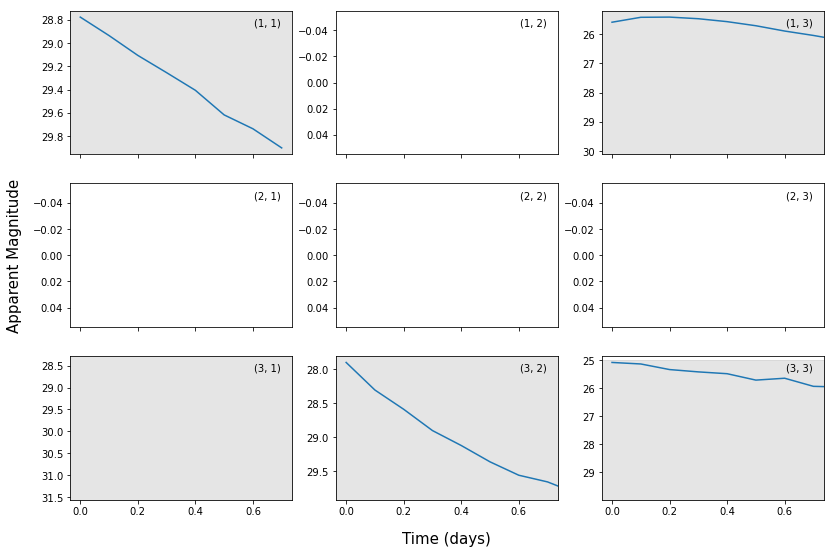

In [ ]:
Functions.PlotLightCurve(Path1, 'u', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=30, PlotSizeRatio=0.75, AlignPeak=False)

The threshold for the magnitude is 45.
The objects plotted are from FileNo=[13, 10, 10], ObjNo=[96, 95, 149]


(array([13, 10, 10]), array([ 96,  95, 149]))

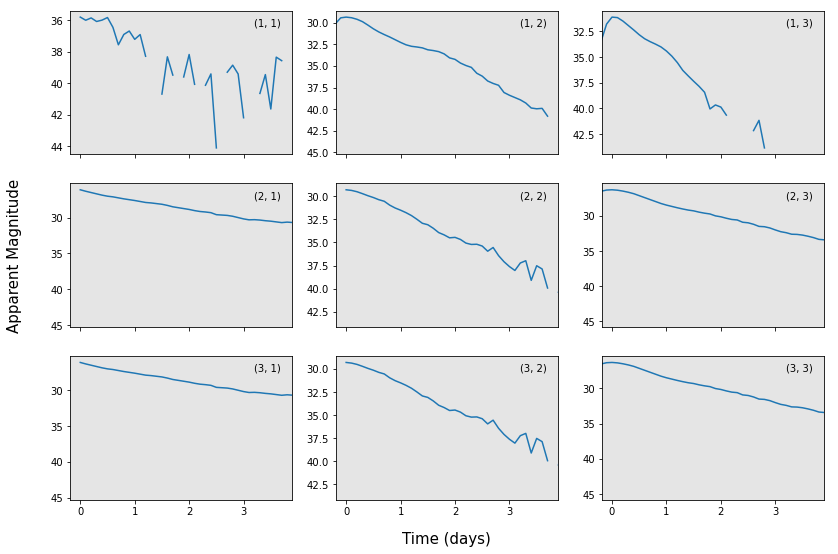

In [ ]:
Functions.PlotLightCurve(Path1, 'u', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=45, PlotSizeRatio=0.75)

The threshold for the magnitude is 45.
The objects plotted are from FileNo=[0, 9, 15], ObjNo=[191, 167, 113]


(array([ 0,  9, 15]), array([191, 167, 113]))

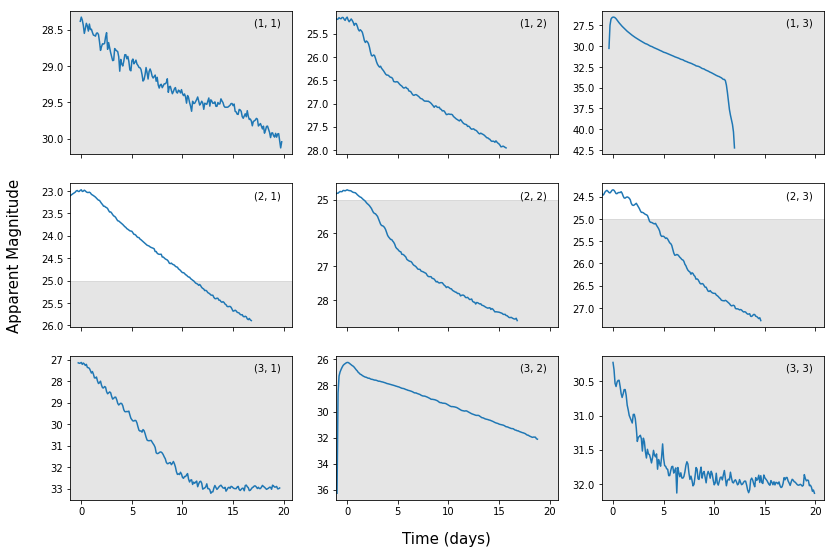

In [ ]:
Functions.PlotLightCurve(Path1, 'Y', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=45, PlotSizeRatio=0.75)

The threshold for the magnitude is 30.
The objects plotted are from FileNo=[16, 11, 5], ObjNo=[194, 24, 110]


(array([16, 11,  5]), array([194,  24, 110]))

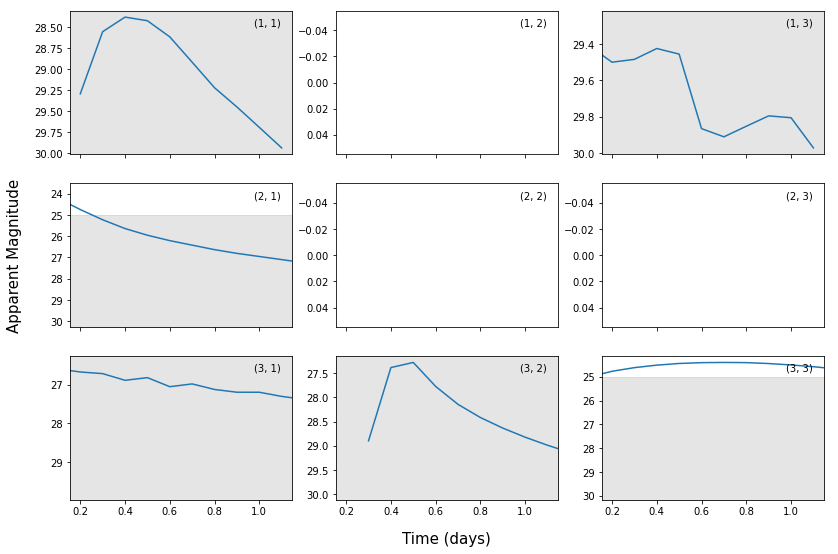

In [ ]:
Functions.PlotLightCurve(Path1, 'g', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=30, PlotSizeRatio=0.75, AlignPeak=Falsese)

The threshold for the magnitude is 45.
The objects plotted are from FileNo=[16, 11, 5], ObjNo=[194, 24, 110]


([16, 11, 5], [194, 24, 110])

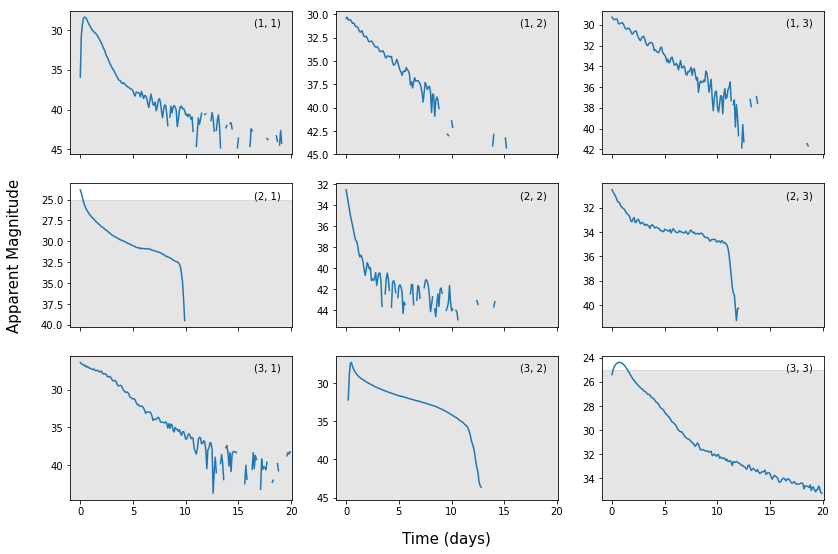

In [ ]:
Functions.PlotLightCurve(Path1, 'g', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=45, PlotSizeRatio=0.75, AlignPeak=False,FileNo=[16, 11, 5], ObjNo=[194, 24, 110])

The threshold for the magnitude is 90.
The objects plotted are from FileNo=[1, 18, 3], ObjNo=[193, 68, 149]


([1, 18, 3], [193, 68, 149])

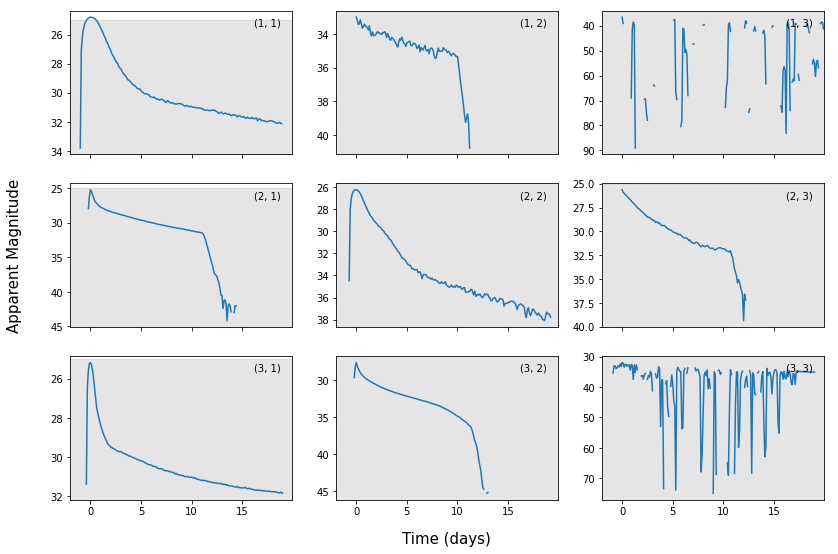

In [ ]:
Functions.PlotLightCurve(Path1, 'g', 'KN_K17', Space=True, FigNo=9, Shadow=25, thr=90, PlotSizeRatio=0.75,FileNo=[1, 18, 3], ObjNo=[193, 68, 149])

The threshold for the magnitude is 90.
The objects plotted are from FileNo=[12, 11, 13], ObjNo=[1063, 1609, 1866]


(array([12, 11, 13]), array([1063, 1609, 1866]))

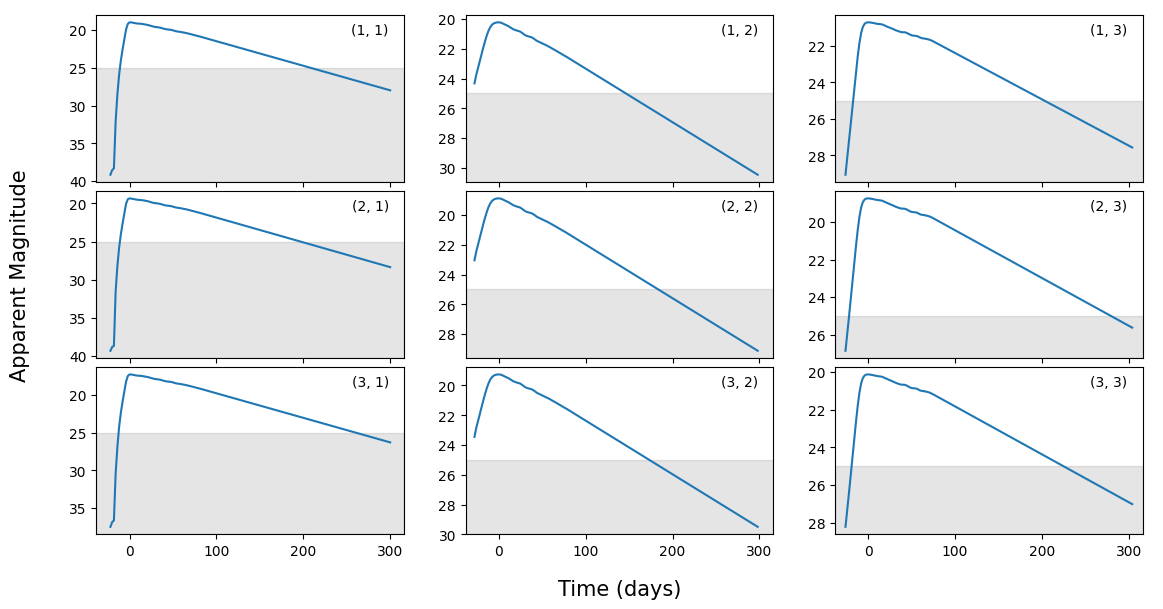

In [19]:
PlotLightCurve(Path3, 'g', 'SNII-Templates', Space=True, FigNo=9, Shadow=25, thr=90, PlotSizeRatio=0.75)

The threshold for the magnitude is 90.
The objects plotted are from FileNo=[9, 12, 18], ObjNo=[1358, 1298, 1350]


(array([ 9, 12, 18]), array([1358, 1298, 1350]))

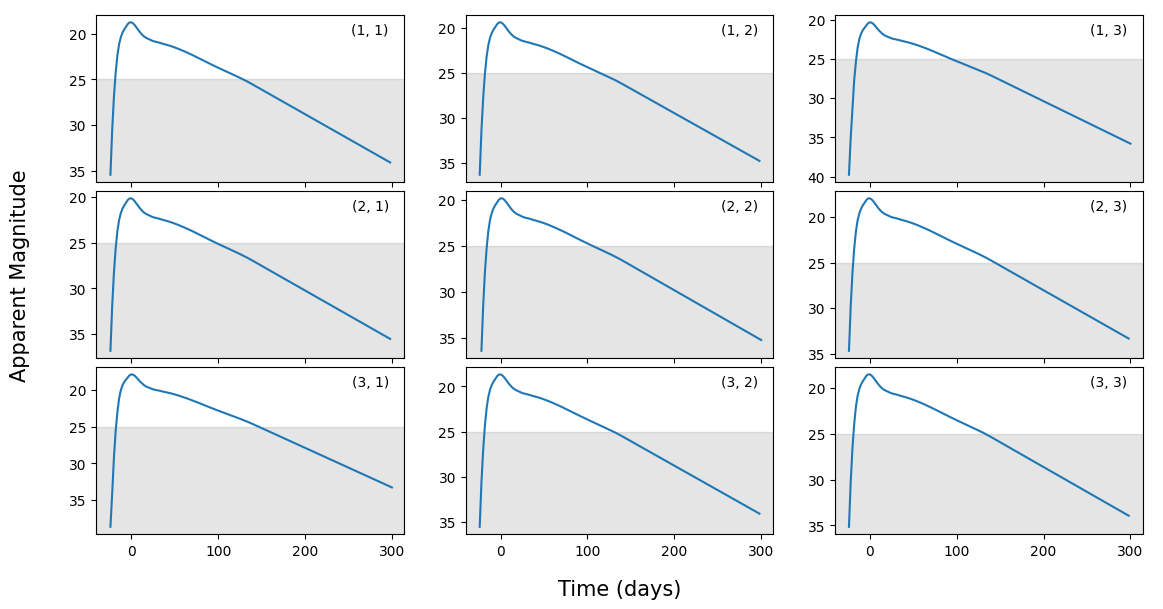

In [21]:
PlotLightCurve(Path3, 'g', 'SNIbc-Templates', Space=True, FigNo=9, Shadow=25, thr=90, PlotSizeRatio=0.75)

The threshold for the magnitude is 90.
The objects plotted are from FileNo=[13, 16, 4], ObjNo=[1196, 228, 1526]


(array([13, 16,  4]), array([1196,  228, 1526]))

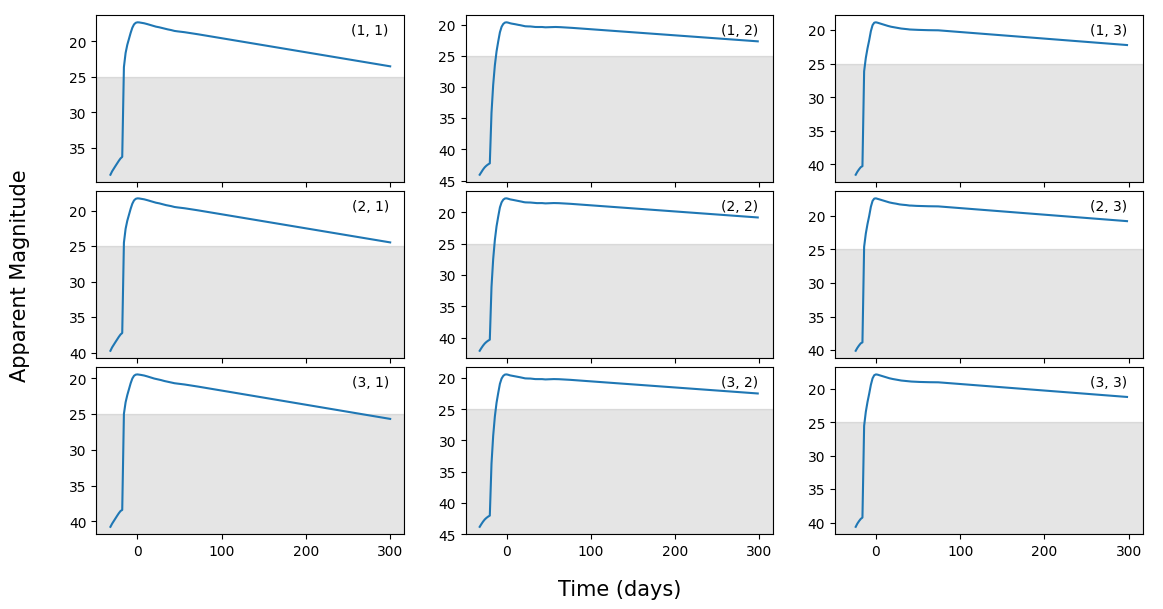

In [22]:
PlotLightCurve(Path3, 'g', 'SNII-Templates', Space=True, FigNo=9, Shadow=25, thr=90, PlotSizeRatio=0.75)

In [23]:
PlotLightCurve(Path3, 'g')

Please provide the event name. Available events are:


['AGN',
 'CART',
 'EB',
 'ILOT',
 'KN_B19',
 'KN_K17',
 'MIRA',
 'Mdwarf',
 'PISN',
 'RRL',
 'SLSN-I',
 'SNII-NMF',
 'SNII-Templates',
 'SNIIn',
 'SNIa-91bg',
 'SNIa-SALT2',
 'SNIax',
 'SNIbc-MOSFIT',
 'SNIbc-Templates',
 'TDE',
 'V19_CC+HostXT',
 'uLens-Binary',
 'uLens-Single-GenLens',
 'uLens-Single_PyLIMA']